# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera, normaltest
import gc
from IPython.display import display
import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Visualisation settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# --- Function to reduce memory consumption ---
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

print("OK.")

OK.


# Loading and Initial Inspection of Data

In [2]:
TRAIN_PATH = '/kaggle/input/hull-tactical-market-prediction/train.csv'

df = pd.read_csv(TRAIN_PATH).set_index('date_id')
df = reduce_mem_usage(df)

print(f"Dataset shape: {df.shape}")
print(f"Time range of data: from {df.index.min()} to {df.index.max()}")

display(df.head())
display(df.tail())

Mem. usage decreased to  3.16 Mb (52.9% reduction)
Dataset shape: (8990, 97)
Time range of data: from 0 to 8989


,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
date_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0024,0.0003,-0.0030
1,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0085,0.0003,-0.0091
2,0,0,0,1,0,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0096,0.0003,-0.0102
3,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0047,0.0003,0.0040
4,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0117,0.0003,-0.0123


,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
date_id,,,,,,,,,,,,,,,,,,,,,
8985,0,0,0,0,0,0,0,0,0,1.5654,...,0.4696,0.8380,1.2268,0.8228,-0.7074,0.1429,-0.6496,0.0025,0.0002,0.0020
8986,0,0,0,0,0,0,0,0,0,1.5629,...,0.6720,0.8380,0.7859,0.8056,-0.7157,0.1961,-0.6683,0.0023,0.0002,0.0018
8987,0,0,1,0,0,0,0,0,0,1.5605,...,0.4815,0.7877,0.8349,0.8234,-0.7239,0.1339,-0.6709,0.0029,0.0002,0.0024
8988,0,0,0,0,0,0,0,0,0,1.5581,...,0.6554,0.7837,0.9940,0.8519,-0.6849,0.1019,-0.6463,0.0083,0.0002,0.0078
8989,0,0,0,0,0,0,0,0,0,1.5557,...,0.0668,0.7837,1.0680,0.8796,-0.7648,0.0790,-0.7057,0.0001,0.0002,-0.0004


In [3]:
df.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
count,"8,990.0000","8,990.0000","8,990.0000","8,990.0000","8,990.0000","8,990.0000","8,990.0000","8,990.0000","8,990.0000","7,206.0000",...,"7,984.0000","7,984.0000","7,478.0000","7,984.0000","7,479.0000","7,984.0000","4,451.0000","8,990.0000","8,990.0000","8,990.0000"
mean,0.0316,0.0316,0.0478,0.5752,0.1907,-0.2380,0.0457,0.1428,0.1432,1.5646,...,0.4896,0.5069,0.3725,0.2872,0.1483,0.3039,0.1292,0.0005,0.0001,0.0001
std,0.1749,0.1749,0.2134,0.4943,0.3928,0.4259,0.2089,0.3499,0.3503,0.6339,...,0.3062,0.3066,1.1533,0.3122,1.3269,0.3511,1.2773,0.0106,0.0001,0.0106
min,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,0.0000,0.3251,...,0.0007,0.0007,-2.7235,0.0007,-2.0276,0.0007,-1.4974,-0.0398,-0.0000,-0.0406
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.1146,...,0.2070,0.2361,-0.4729,0.0007,-0.7972,0.0007,-0.7382,-0.0043,0.0000,-0.0048
50%,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.5167,...,0.4924,0.5192,0.2752,0.1802,-0.0977,0.1010,-0.1708,0.0007,0.0001,0.0003
75%,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.8770,...,0.7606,0.7725,1.1251,0.5159,0.7958,0.5900,0.6859,0.0059,0.0002,0.0055
max,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,4.8439,...,1.0000,1.0000,6.8099,1.0000,12.6783,1.0000,12.9975,0.0407,0.0003,0.0406


# Analysis of Missing Values

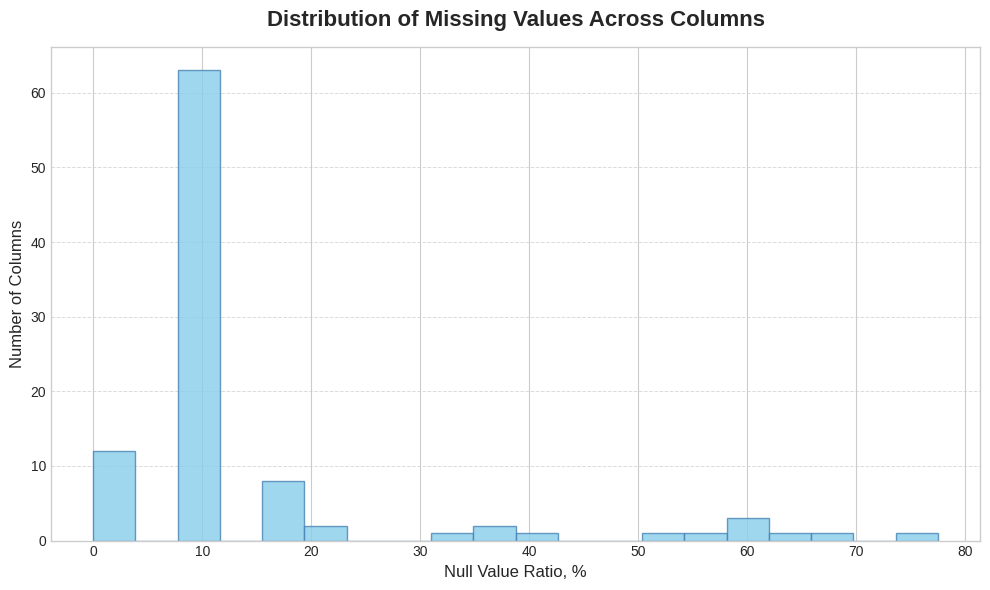

In [4]:
missing_ratio = df.isnull().sum() * 100 / df.shape[0]

plt.figure(figsize=(10, 6))
plt.hist(missing_ratio, bins=20, color='skyblue', edgecolor='steelblue', alpha=0.8)

plt.title('Distribution of Missing Values Across Columns', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Null Value Ratio, %', fontsize=12)
plt.ylabel('Number of Columns', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7)
plt.tight_layout()
plt.show()

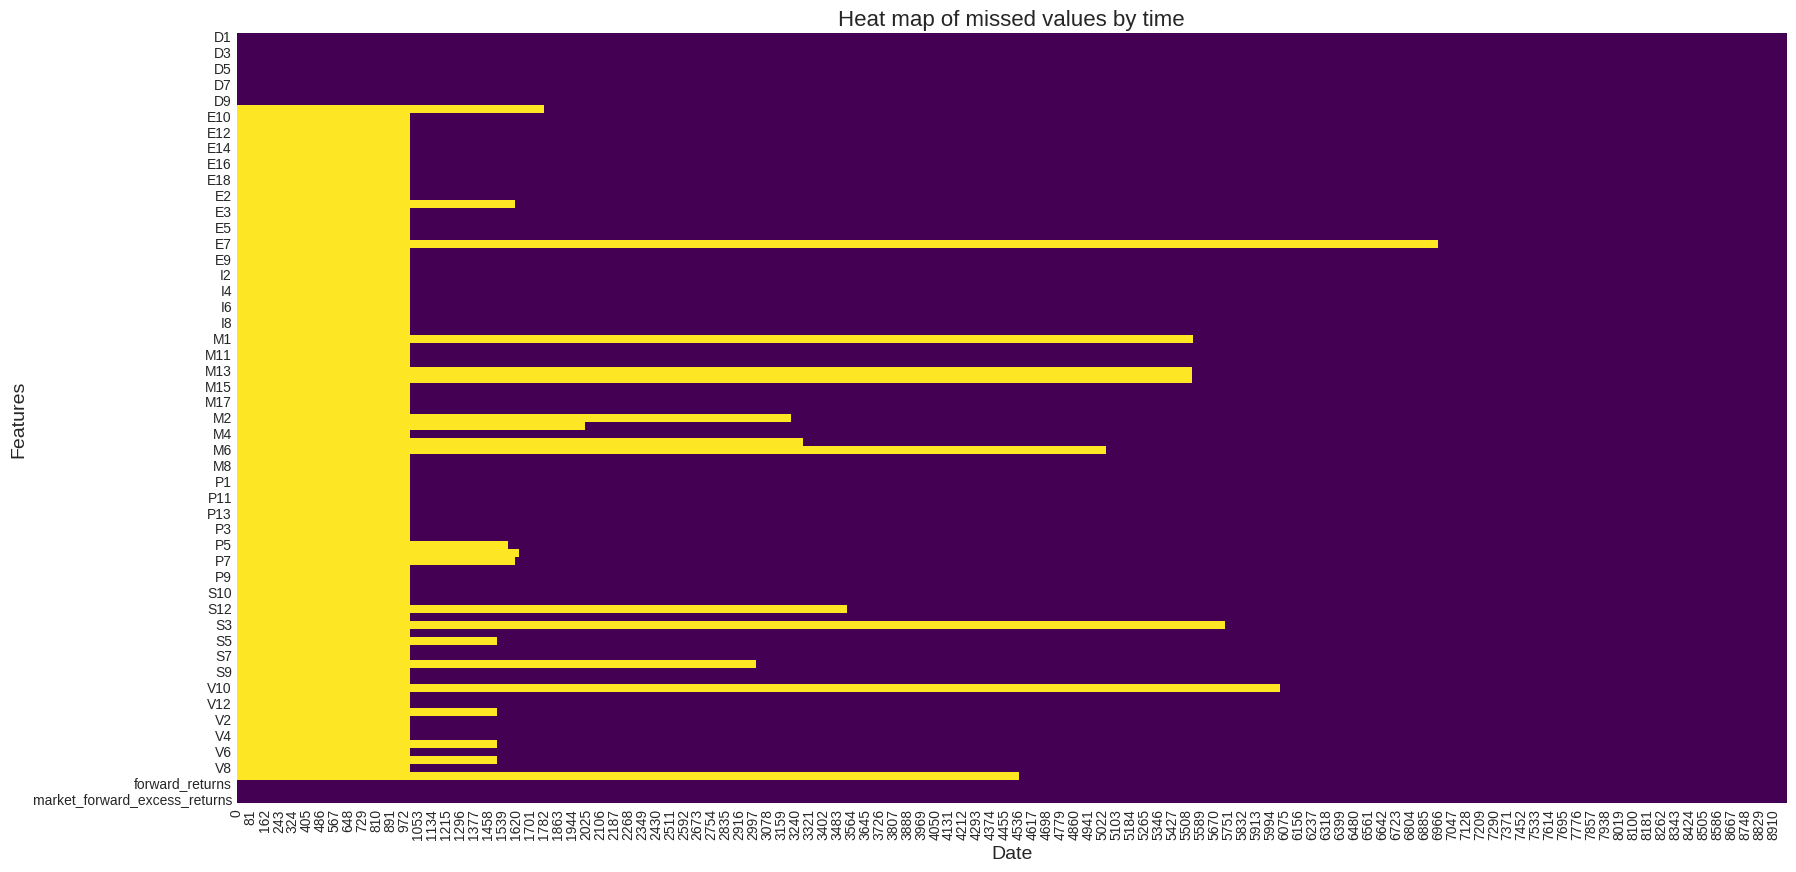

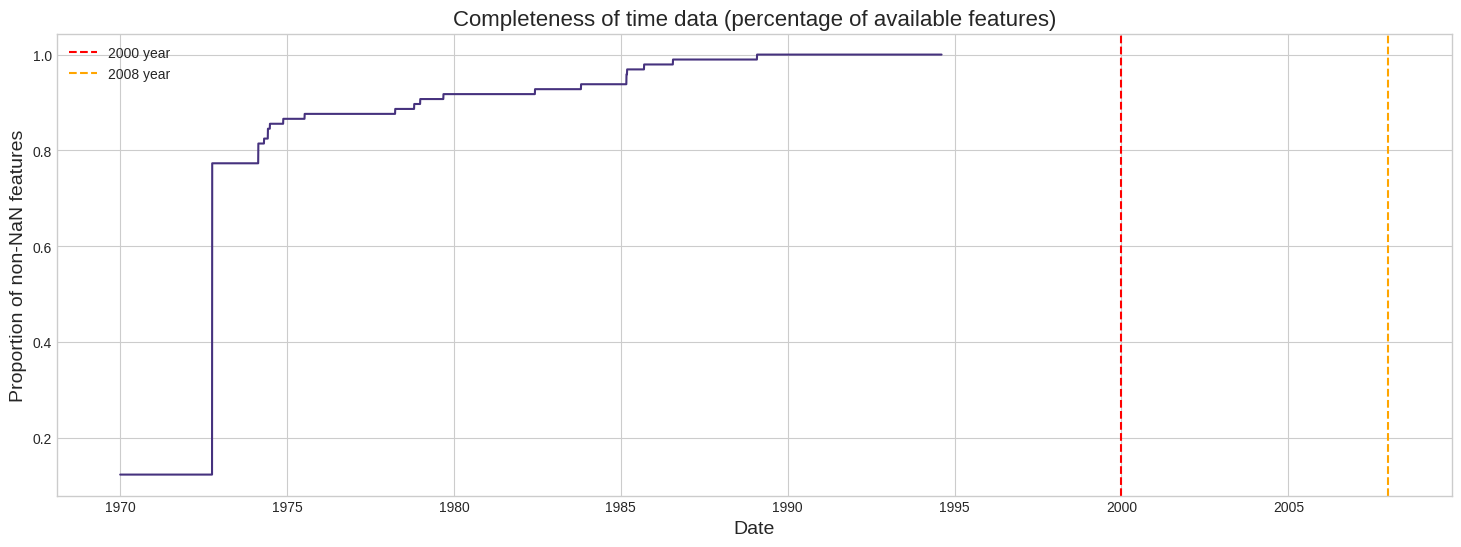

In [5]:
plt.figure(figsize=(20, 10))
# Visualize gaps (yellow - there is data, purple - not)
# Transpose so that the signs are on the Y axis and the time is on the X axis
sns.heatmap(df.isnull().T, cmap='viridis', cbar=False)
plt.title('Heat map of missed values by time')
plt.xlabel('Date')
plt.ylabel('Features')
plt.show()

completeness_by_date = df.notnull().mean(axis=1)

plt.figure(figsize=(18, 6))
completeness_by_date.plot()
plt.title('Completeness of time data (percentage of available features)')
plt.ylabel('Proportion of non-NaN features')
plt.xlabel('Date')
plt.axvline(pd.to_datetime('2000-01-01'), color='red', linestyle='--', label='2000 year')
plt.axvline(pd.to_datetime('2008-01-01'), color='orange', linestyle='--', label='2008 year')
plt.legend()
plt.show()

# Target Variable Analysis
Our goal is to predict excess returns. Let's create this variable and examine it.

<Figure size 1800x600 with 0 Axes>

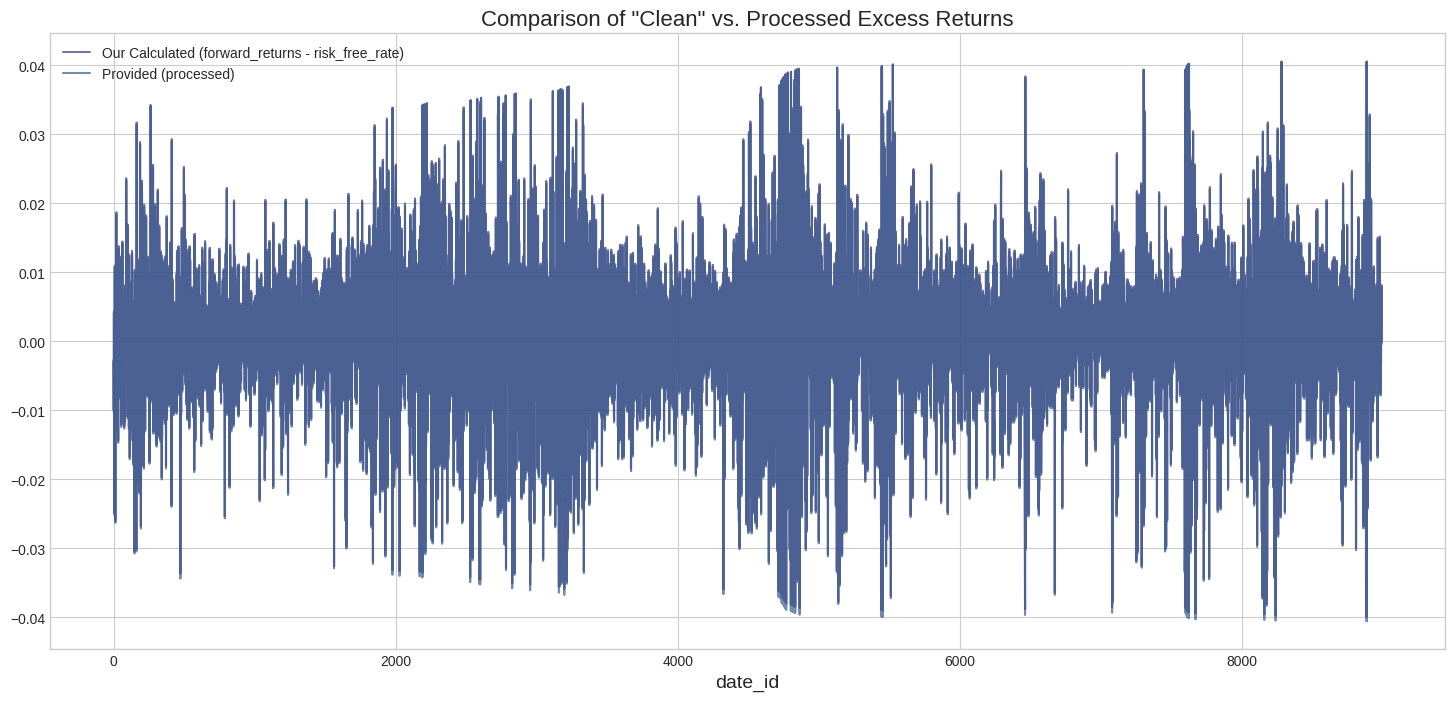

The plots are very similar. The provided variable is likely a winsorized version of our calculated one.
For our analysis, we'll use our 'clean' version as it's more fundamental.
Jarque-Bera Test: Statistic=1838.26, p-value=0.000
The null hypothesis of normality is rejected. The distribution has 'heavy tails', which is typical for financial markets.


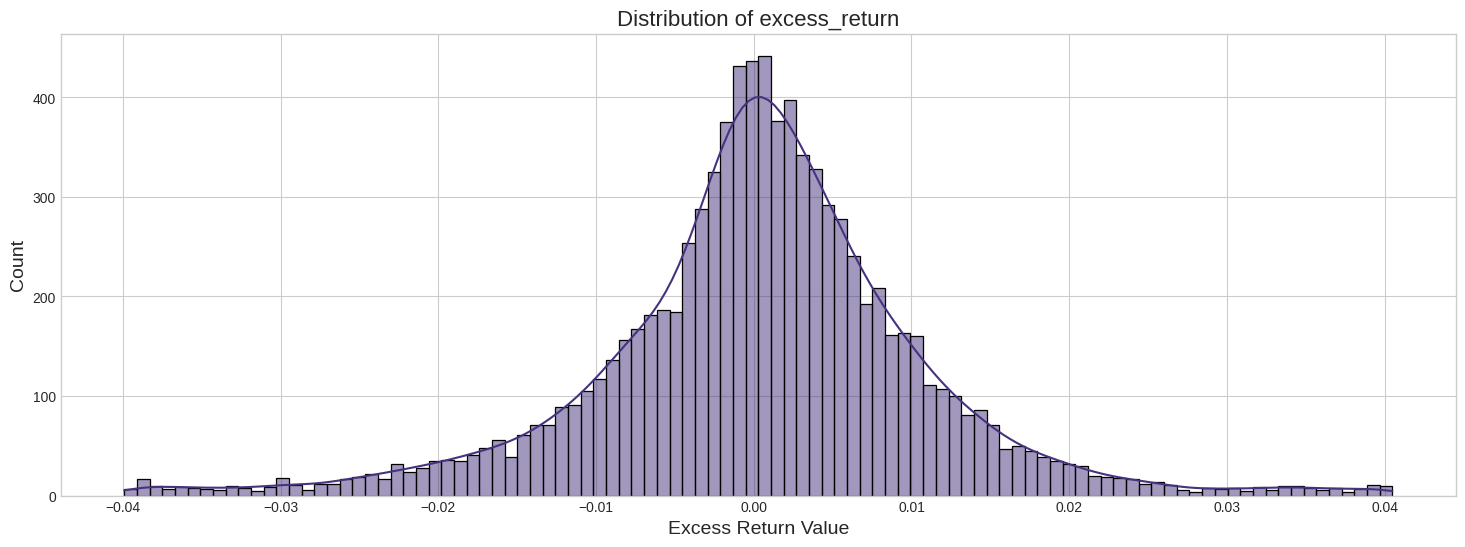

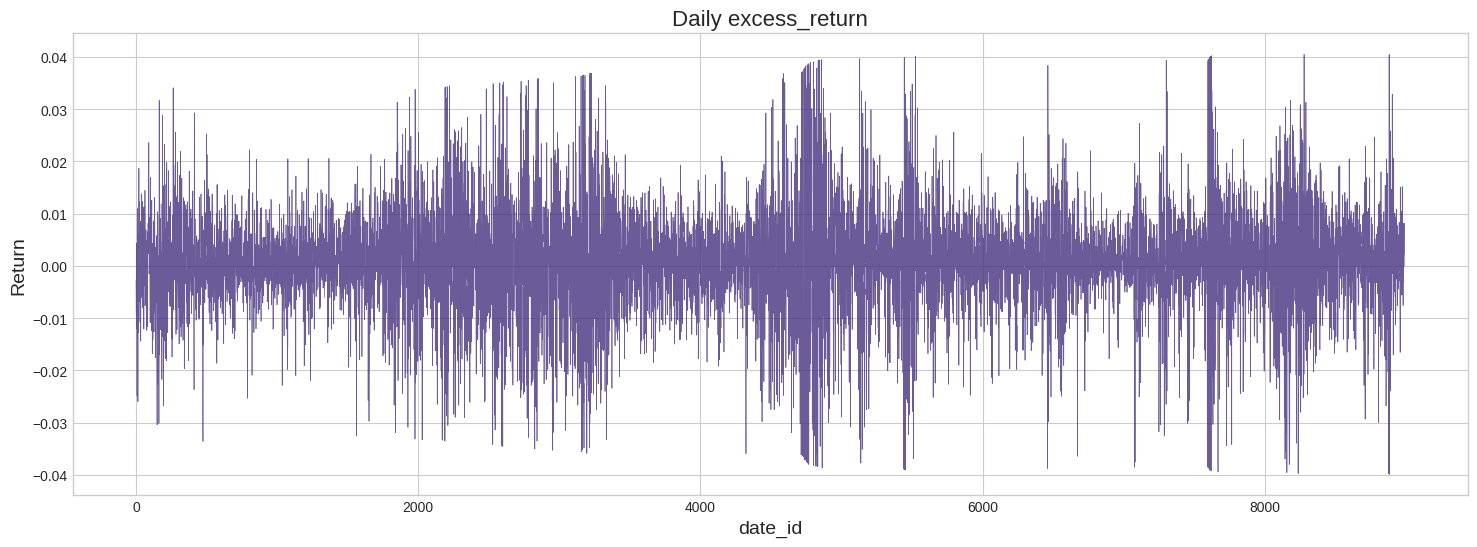

Volatility clustering is evident: periods of high and low variance (e.g., crises of 2000, 2008, 2020).


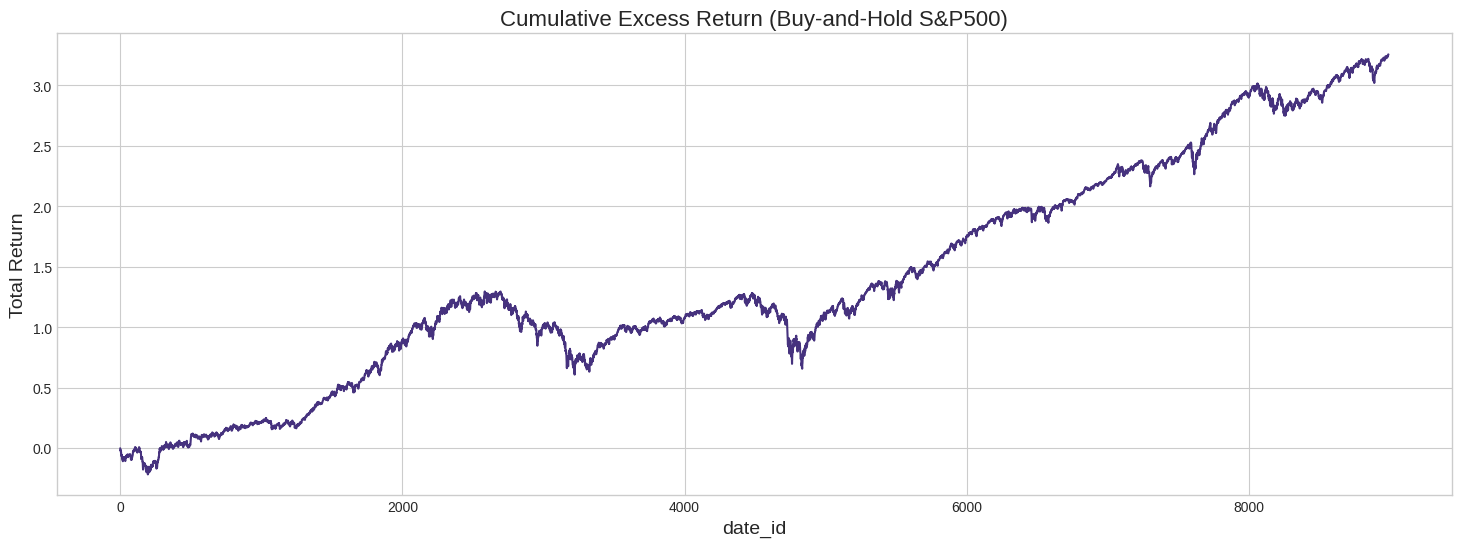

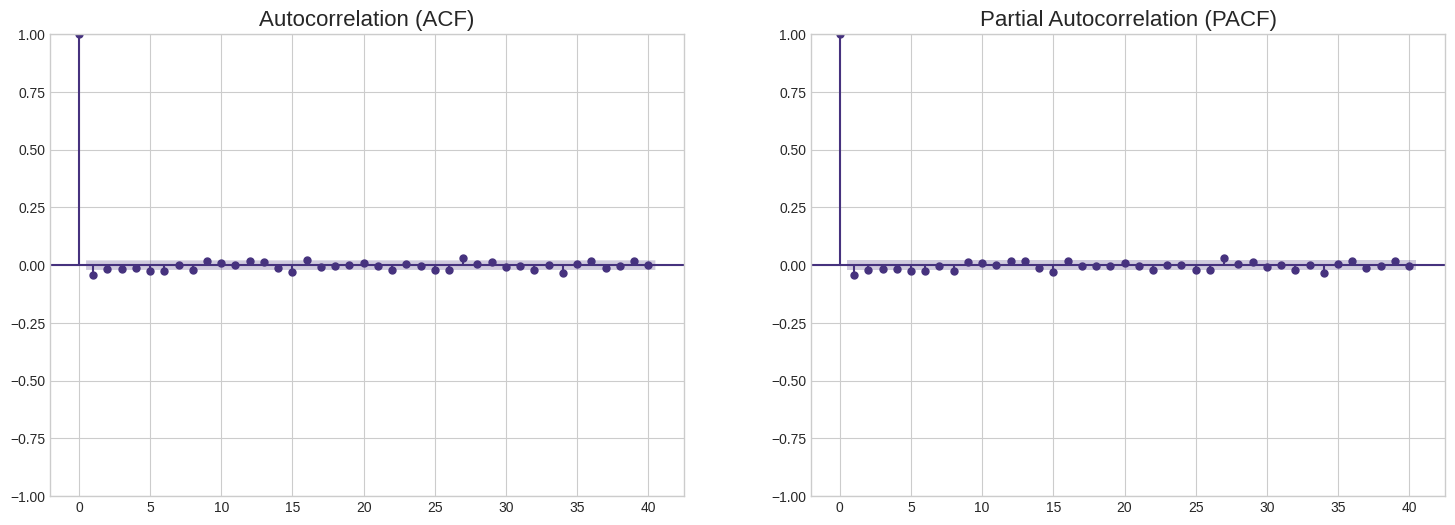

Autocorrelation is very weak and close to zero. This supports the efficient-market hypothesis at short lags.
This means that simply using yesterday's return to predict today's is a poor strategy.


In [6]:
df['excess_return'] = df['forward_returns'] - df['risk_free_rate']

TARGET_NAME = 'excess_return'

plt.figure(figsize=(18, 6))
df[[TARGET_NAME, 'market_forward_excess_returns']].plot(alpha=0.7)
plt.title('Comparison of "Clean" vs. Processed Excess Returns')
plt.legend(['Our Calculated (forward_returns - risk_free_rate)', 'Provided (processed)'])
plt.show()
print("The plots are very similar. The provided variable is likely a winsorized version of our calculated one.")
print("For our analysis, we'll use our 'clean' version as it's more fundamental.")

# 1. Target Distribution
plt.figure(figsize=(18, 6))
sns.histplot(df[TARGET_NAME].dropna(), kde=True, bins=100)
plt.title(f'Distribution of {TARGET_NAME}')
plt.xlabel('Excess Return Value')

# Normality Test
stat, p_value = jarque_bera(df[TARGET_NAME].dropna())
print(f"Jarque-Bera Test: Statistic={stat:.2f}, p-value={p_value:.3f}")
if p_value < 0.05:
    print("The null hypothesis of normality is rejected. The distribution has 'heavy tails', which is typical for financial markets.")
plt.show()

# 2. Behavior Over Time
plt.figure(figsize=(18, 6))
df[TARGET_NAME].plot(alpha=0.8, style='-', lw=0.5)
plt.title(f'Daily {TARGET_NAME}')
plt.ylabel('Return')
plt.show()
print("Volatility clustering is evident: periods of high and low variance (e.g., crises of 2000, 2008, 2020).")

# 3. Cumulative Return (Buy-and-Hold Strategy)
plt.figure(figsize=(18, 6))
df[TARGET_NAME].cumsum().plot()
plt.title('Cumulative Excess Return (Buy-and-Hold S&P500)')
plt.ylabel('Total Return')
plt.show()

# 4. Autocorrelation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plot_acf(df[TARGET_NAME].dropna(), lags=40, ax=ax1, title='Autocorrelation (ACF)')
plot_pacf(df[TARGET_NAME].dropna(), lags=40, ax=ax2, title='Partial Autocorrelation (PACF)')
plt.show()
print("Autocorrelation is very weak and close to zero. This supports the efficient-market hypothesis at short lags.")
print("This means that simply using yesterday's return to predict today's is a poor strategy.")

# Feature Analysis by Group

## Time Series

Dynamically determined start_id: 5540 (the first day with >= 95% data completeness)
Filtered dataset shape: (3450, 98)


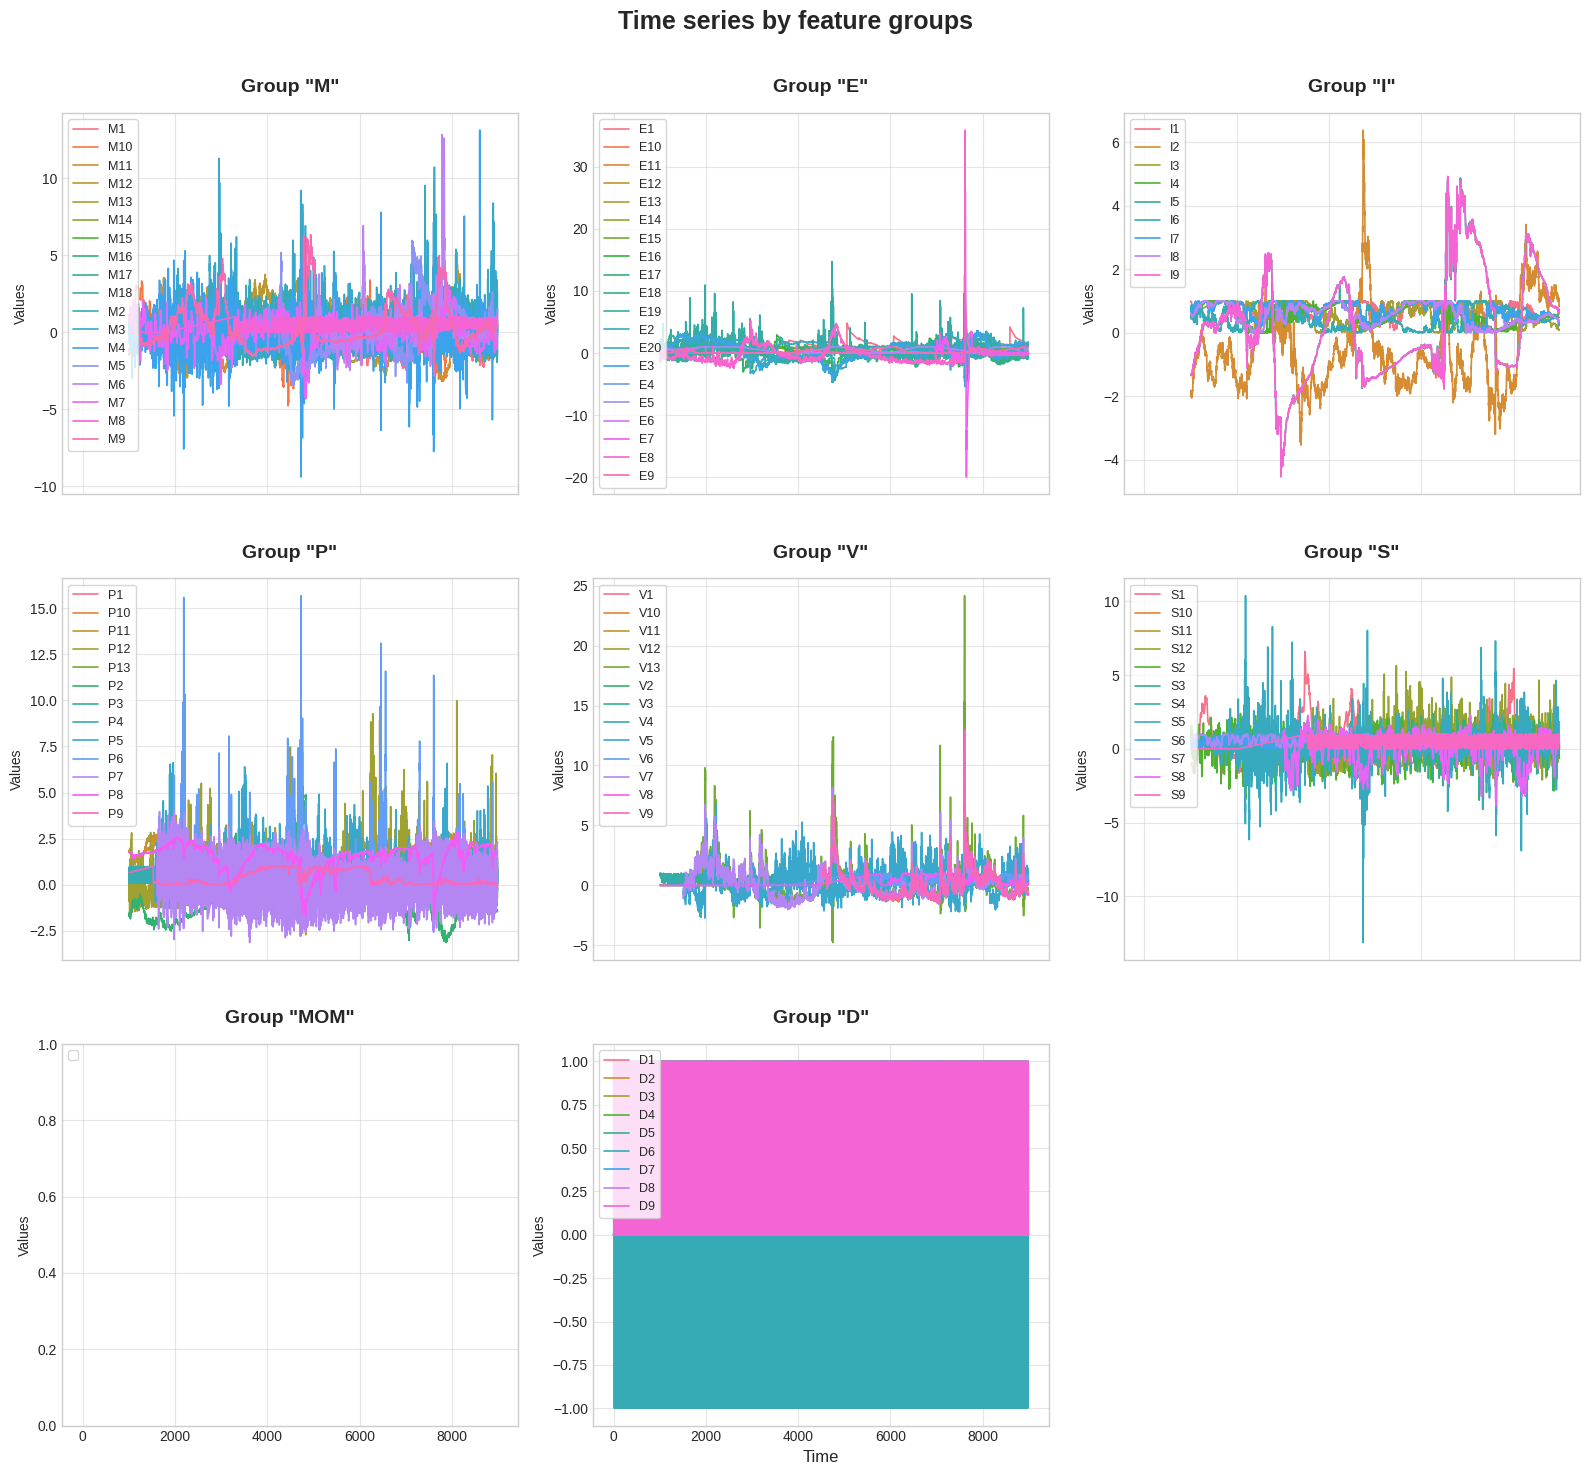

In [7]:
completeness_by_date = df.notnull().mean(axis=1)
try:
    start_id = (completeness_by_date >= 0.95).idxmax()
    print(f"Dynamically determined start_id: {start_id} (the first day with >= 95% data completeness)")
except ValueError:
    start_id = df.index[int(len(df) * 0.5)]
    print(f"Warning: Could not find a 95% completeness point. Falling back to a default start_id: {start_id}")
    
df_filtered = df.loc[df.index >= start_id].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")

feature_cols = [col for col in df.columns if '*' not in col and col not in ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'excess_return']]

groups = {
    'M': [f for f in feature_cols if f.startswith('M')],
    'E': [f for f in feature_cols if f.startswith('E')],  
    'I': [f for f in feature_cols if f.startswith('I')],  
    'P': [f for f in feature_cols if f.startswith('P')],
    'V': [f for f in feature_cols if f.startswith('V')],   
    'S': [f for f in feature_cols if f.startswith('S')],  
    'MOM': [f for f in feature_cols if f.startswith('MOM')],
    'D': [f for f in feature_cols if f.startswith('D')]   
}

groups_filtered = {key: [col for col in item if col in df.columns] for key, item in groups.items()}

n_groups = len(groups_filtered)
cols = 3
rows = math.ceil(n_groups / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows), sharex=True)
axes = axes.flatten() if n_groups > 1 else [axes]

for idx, (key, columns) in enumerate(groups_filtered.items()):
    ax = axes[idx]
    colors = sns.color_palette("husl", len(columns))
    
    for i, col in enumerate(columns):
        ax.plot(df.index, df[col], label=col, color=colors[i], linewidth=1.2)

    ax.set_title(f'Group "{key}"', fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=9, frameon=True, fancybox=True, shadow=False)
    ax.grid(True, alpha=0.5)
    ax.set_ylabel("Values", fontsize=10)

for idx in range(n_groups, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Time series by feature groups", fontsize=18, fontweight='bold', y=0.98)
plt.xlabel("Time", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

## Correlation

Dynamically determined start_id: 5540 (the first day with >= 95% data completeness)
Filtered dataset shape: (3450, 98)

Analyzing feature correlations with the target variable (excess_return):


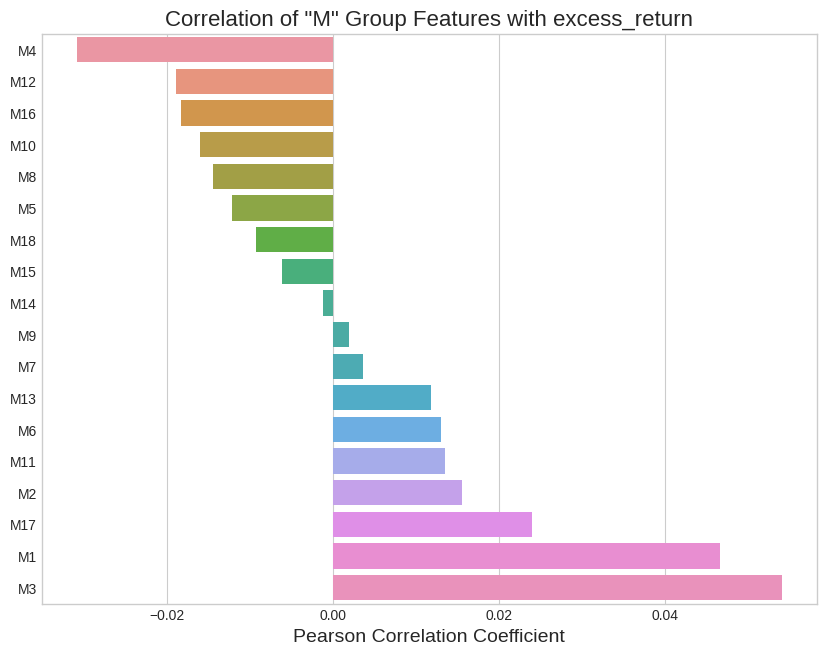

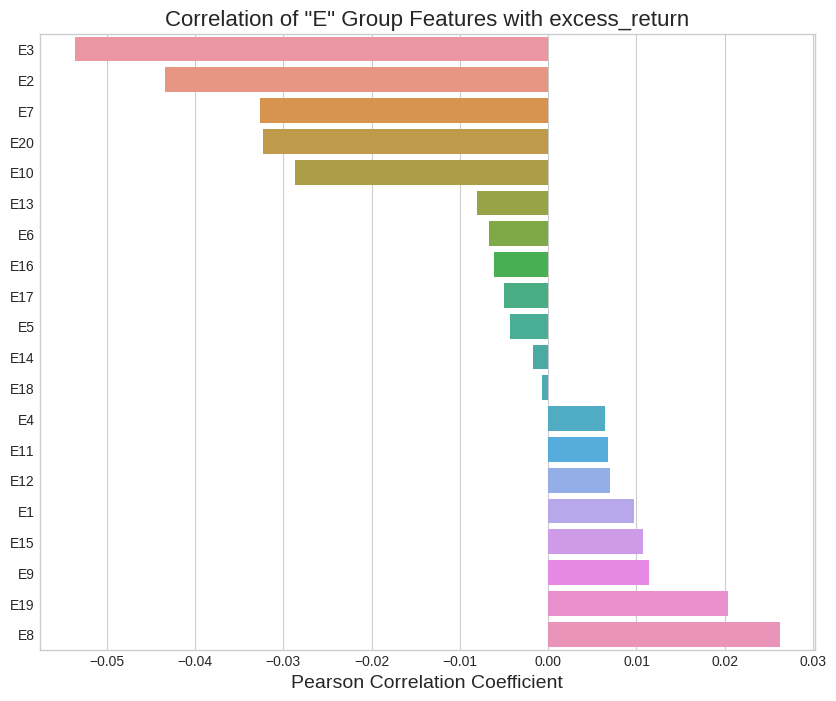

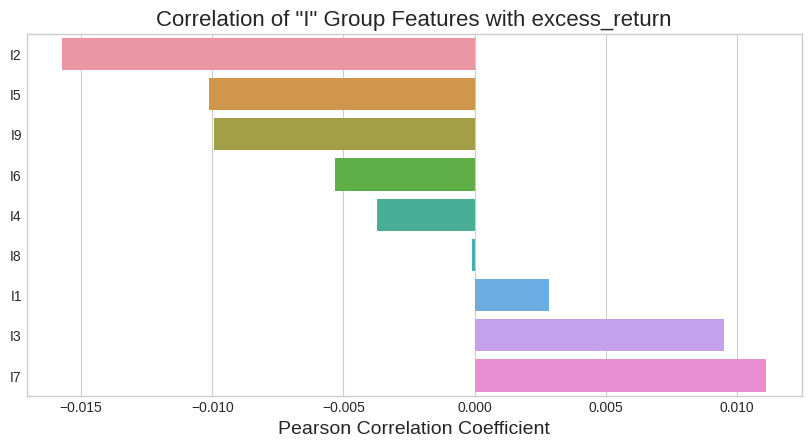

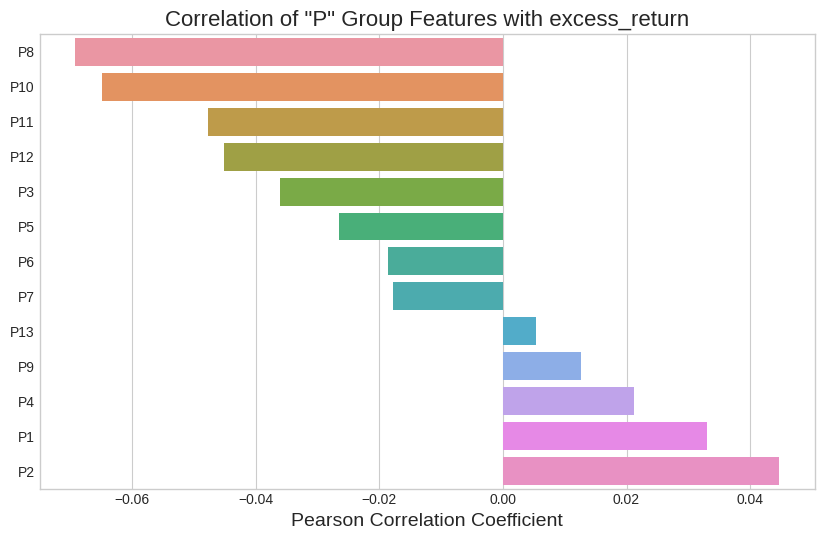

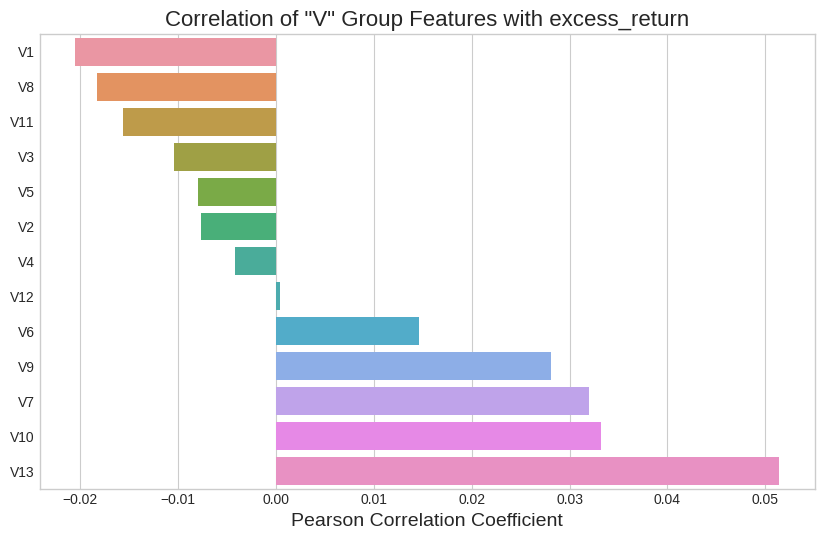

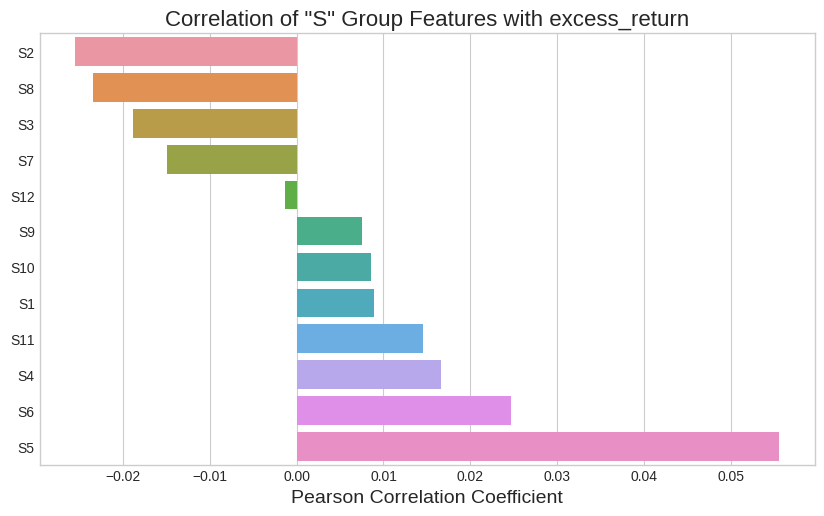

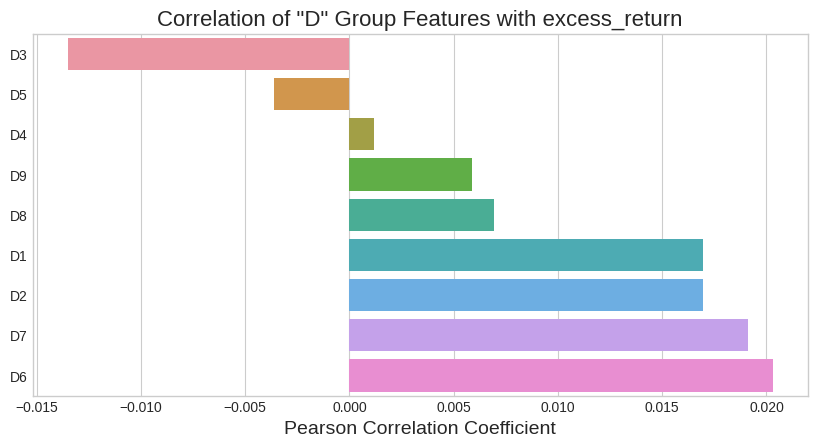

In [8]:
completeness_by_date = df.notnull().mean(axis=1)
try:
    start_id = (completeness_by_date >= 0.95).idxmax()
    print(f"Dynamically determined start_id: {start_id} (the first day with >= 95% data completeness)")
except ValueError:
    start_id = df.index[int(len(df) * 0.5)]
    print(f"Warning: Could not find a 95% completeness point. Falling back to a default start_id: {start_id}")
    
df_filtered = df.loc[df.index >= start_id].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")

feature_cols = [col for col in df.columns if '*' not in col and col not in ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'excess_return']]

groups = {
    'M': [f for f in feature_cols if f.startswith('M')],
    'E': [f for f in feature_cols if f.startswith('E')],  
    'I': [f for f in feature_cols if f.startswith('I')],  
    'P': [f for f in feature_cols if f.startswith('P')],
    'V': [f for f in feature_cols if f.startswith('V')],   
    'S': [f for f in feature_cols if f.startswith('S')],  
    'MOM': [f for f in feature_cols if f.startswith('MOM')],
    'D': [f for f in feature_cols if f.startswith('D')]   
}

if TARGET_NAME in df_filtered.columns:
    correlations = df_filtered[feature_cols + [TARGET_NAME]].corr(method='pearson')[TARGET_NAME].drop(TARGET_NAME)

    print("\nAnalyzing feature correlations with the target variable (excess_return):")

    for prefix, features in groups.items():
        if not features: continue

        group_corr_series = correlations.reindex(features).dropna()

        if group_corr_series.empty:
            print(f"No correlations to plot for group '{prefix}'.")
            continue

        plt.figure(figsize=(10, len(group_corr_series) * 0.3 + 2))
        group_corr_series = group_corr_series.sort_values()

        sns.barplot(x=group_corr_series.values, y=group_corr_series.index, orient='h')
        plt.title(f'Correlation of "{prefix}" Group Features with {TARGET_NAME}')
        plt.xlabel('Pearson Correlation Coefficient')
        plt.show()
else:
    print(f"Target '{TARGET_NAME}' not found in df_filtered. Skipping correlation plots.")

# Correlation Heatmap


Generating heatmap for group 'D'...


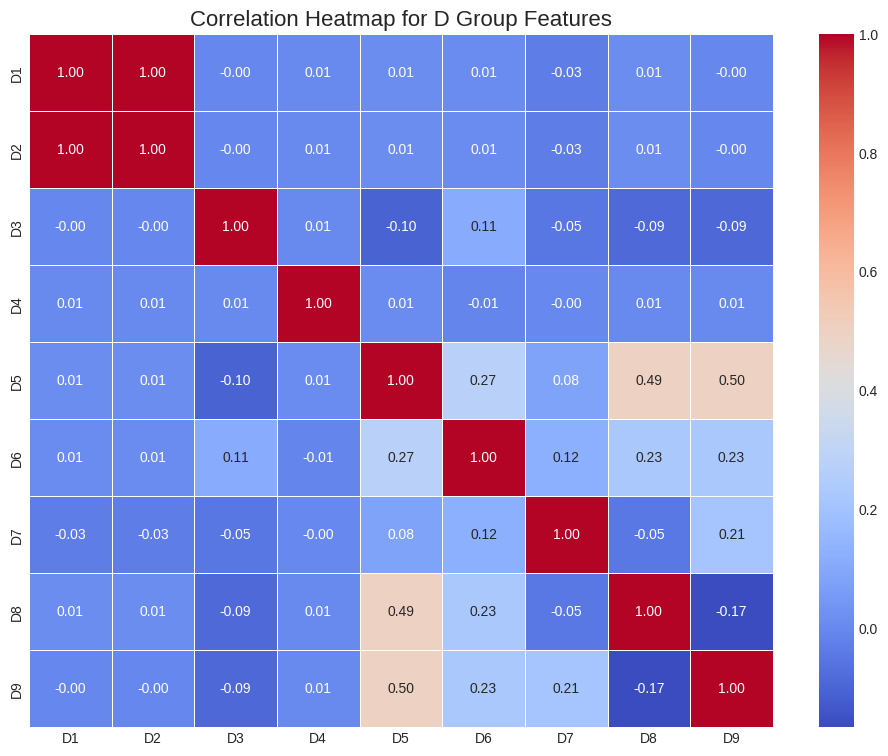


Generating heatmap for group 'E'...


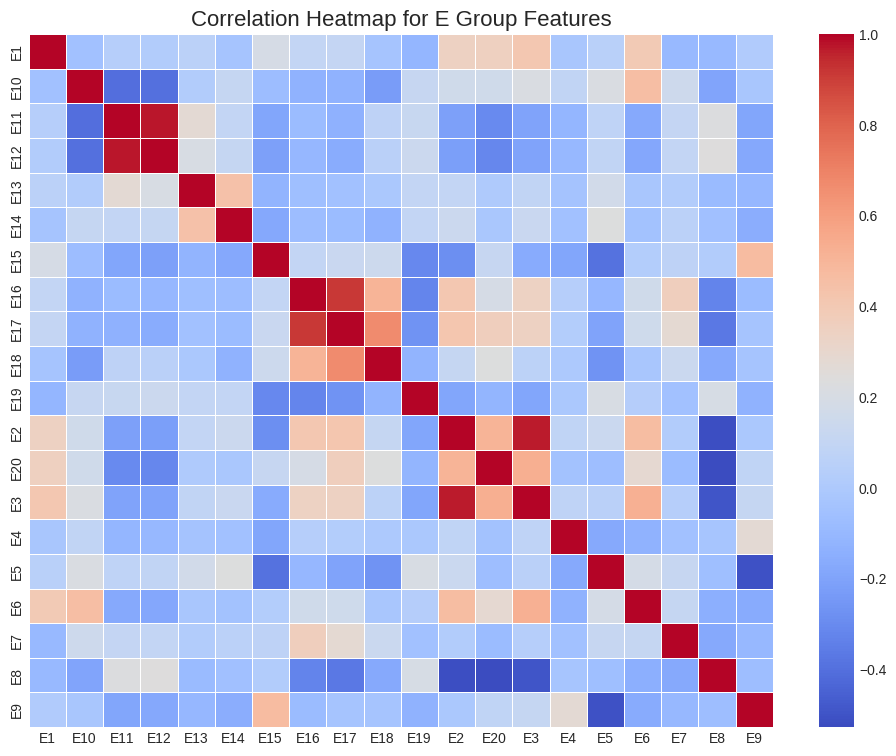


Generating heatmap for group 'I'...


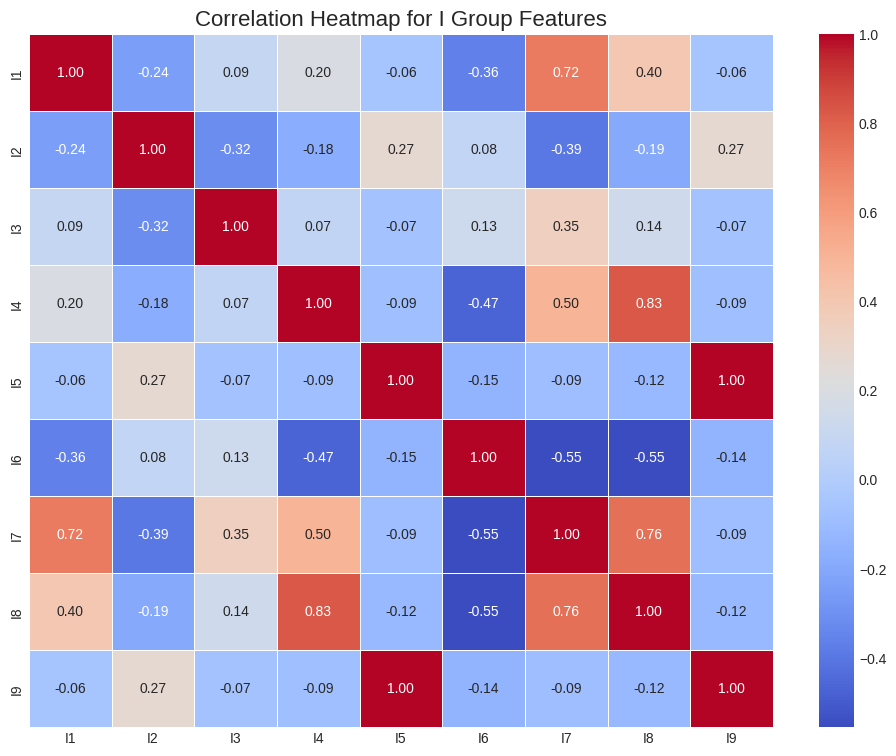


Generating heatmap for group 'M'...


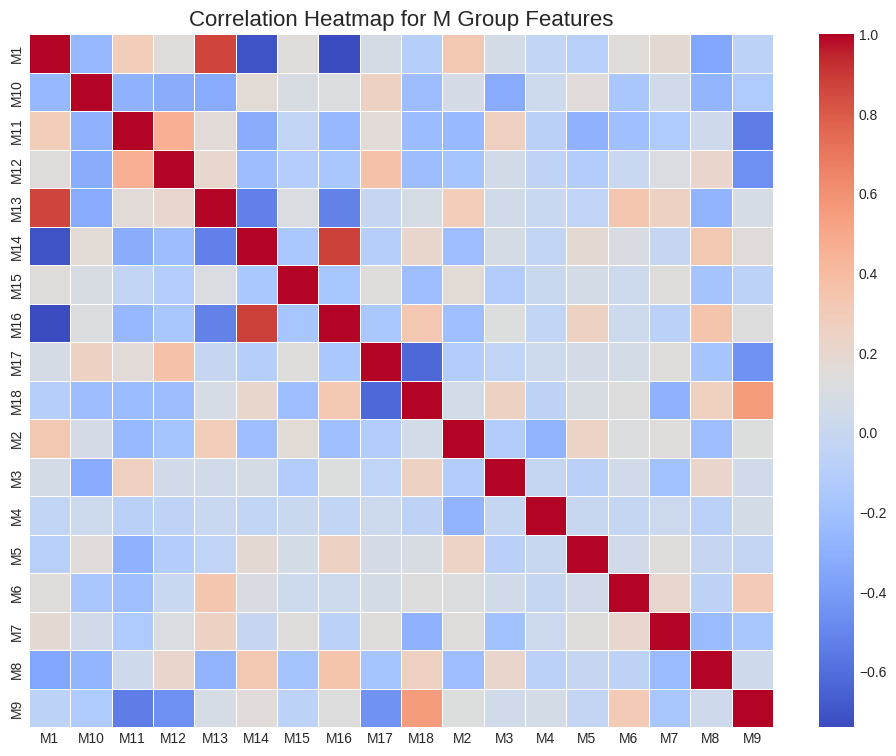


Generating heatmap for group 'P'...


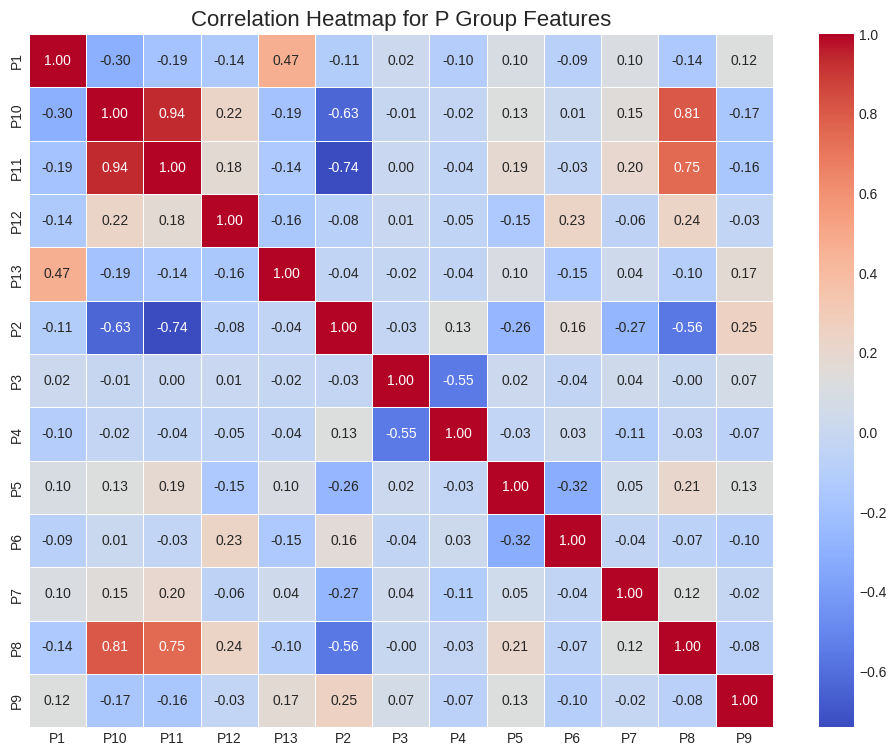


Generating heatmap for group 'S'...


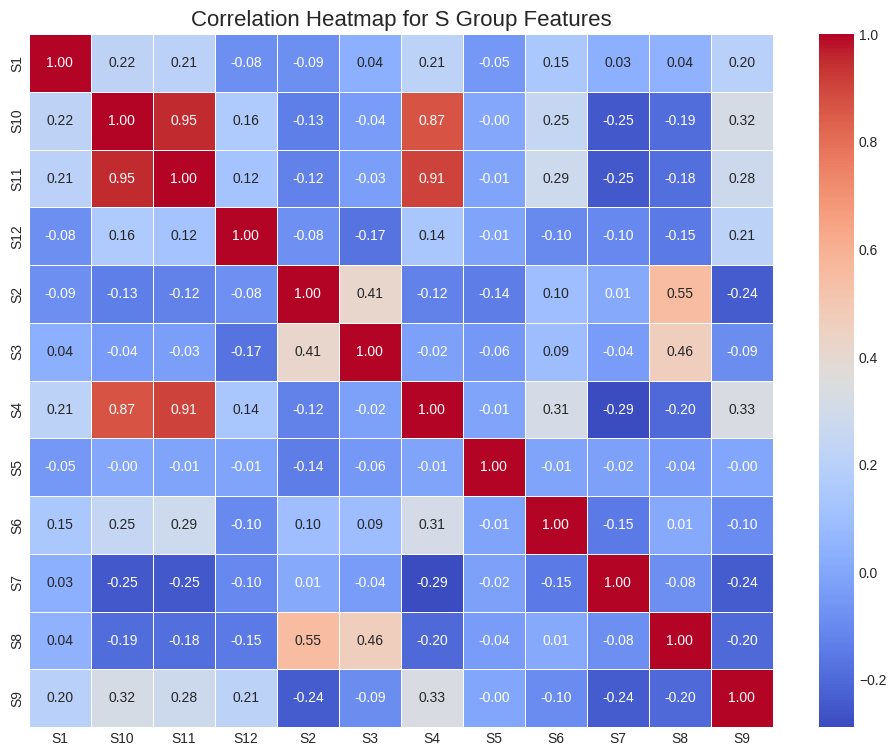


Generating heatmap for group 'V'...


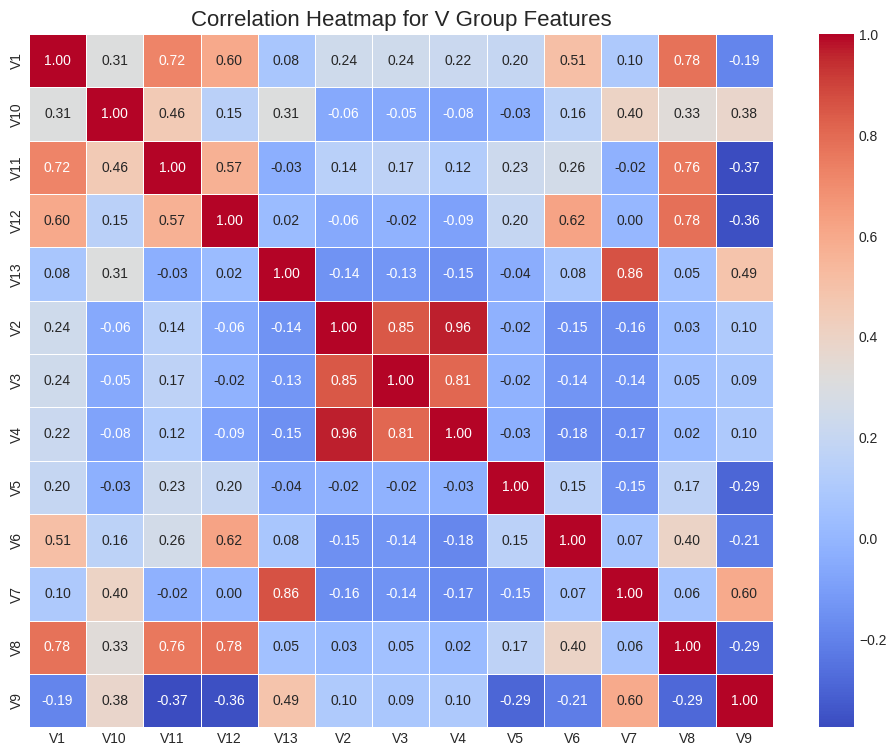

In [9]:
df_imputed = df.fillna(method='ffill').fillna(method='bfill')

feature_categories = ['D', 'E', 'I', 'M', 'P', 'S', 'V']
feature_groups = {cat: [col for col in df_imputed.columns if col.startswith(cat)] for cat in feature_categories}

for category, features in feature_groups.items():
    if len(features) < 2:
        print(f"\nGroup '{category}' has fewer than 2 features, skipping the heatmap.")
        continue

    print(f"\nGenerating heatmap for group '{category}'...")

    corr_matrix = df_imputed[features].corr()

    show_annotations = len(features) < 15

    plt.figure(figsize=(12, 9))
    sns.heatmap(
        corr_matrix,
        annot=show_annotations,
        cmap='coolwarm',       
        fmt='.2f',             
        linewidths=.5
    )
    plt.title(f'Correlation Heatmap for {category} Group Features', fontsize=16)
    plt.show()

# Some Verdicts

Dataset consist of 98 columns: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'excess_return']

Train df contains 8990 lines and 98 columns

Top 5 signs by the number of passes:
E7    0.7752
V10   0.6729
S3    0.6377
M1    0.6170
M14   0.6162
dtype: float64

Top 20 features by correlation: 
market_forward_excess_returns   1.0000
excess_return                   1.0000
forward_ret

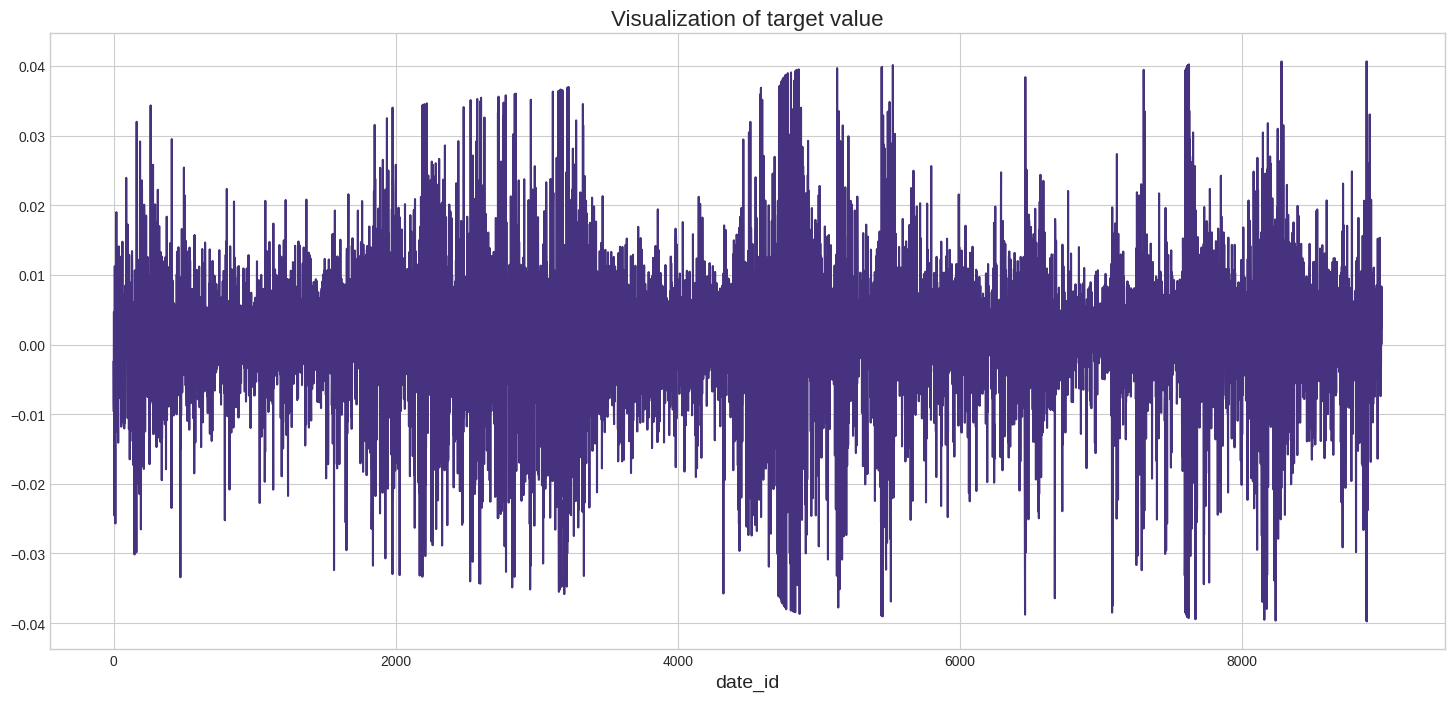

In [10]:
print(f"Dataset consist of {len(list(df))} columns: {list(df)}")
print()
print(f"Train df contains {df.shape[0]} lines and {df.shape[1]} columns")
print()
print(f"Top 5 signs by the number of passes:\n{df.isnull().mean().sort_values(ascending=False).head()}")
print()
df['forward_returns'].plot(title='Visualization of target value')
print(f"Top 20 features by correlation: \n{df.corrwith(df['market_forward_excess_returns']).abs().sort_values(ascending=False).head(20)}")

forward_returns_data = df['forward_returns'].dropna()
stat, p_value = normaltest(forward_returns_data)
print(f"Normality test (D'Agostino): p-value = {p_value:.4f}")
if p_value > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")
